# Modellierung der jährlichen erwarteten KfZ-Schadenhöhe 

## 1. Einleitung: Aufgabenstellung und Relevanz 

Um die Wirtschaftlichkeit einer Versicherung zu gewährleisten, dürfen die Ausgaben einer Versicherung die Einnahmen langfristig nicht übersteigen. Daher haben die durch Schäden entstandenen Kosten für die Berechnung eines fairen KfZ-Versicherungsbeitrags eine besondere Relevanz.
Im Folgenden werden Daten eines französischen Automobilversicherers verwendet, um die Risikomerkmale zu analysieren, die in dem Kontext der Schadenhöhe eine Rolle spielen. Desweiteren wird unter zu Hilfenahme dieser Risikomerkmale ein Modell zur Schätzung der jährlichen Schadenhöhe erstellt. 

**Datensatzbeschreibung**:

*freMTPL2freq*
- `IDpol`: ID des Vertrags 
- `ClaimNb`: Anzahl Schäden im Versicherungszeitraum
- `Exposure`: Länge des Versicherungszeitraums (in Jahren) [Komponente der abhängigen Variable]
- `Area`: Area-Code des Versicherungsnehmers [unabhängige Variable] 
- `VehPower`: Leistung des versicherten Kfz [unabhängige Variable] 
- `VehAge`: Alter des versicherten Kfz [unabhängige Variable] 
- `DrivAge`: Alter des Versicherungsnehmers [unabhängige Variable] 
- `BonusMalus`: Schadenfreiheitsrabatt (französische Entsprechung der Schadenfreiheitsklasse) [unabhängige Variable] 
- `VehBrand`: Marke des versicherten Kfz [unabhängige Variable] 
- `VehGas`: Antrieb des versicherten Kfz [unabhängige Variable] 
- `Density`: Anzahl der Einwohner pro km2 im Wohnort des Versicherungsnehmers [unabhängige Variable] 
- `Region`: Region des Versicherungsnehmers [unabhängige Variable] 

*freMTPL2sev*
- `IDpol`: ID des Vertrags 
- `ClaimAmount`: Höhe der einzelnen Schadenaufwände (mehrere Einträge pro Vertrag, falls im 
Zeitraum mehrere Schäden vorhanden waren.) [Komponente der abhängigen Variable] 


In [1]:
import pandas as pd 
import arff
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
pd.set_option('display.max_columns', 50) #replace n with the number of columns you want to see completely
pd.set_option('display.max_rows', 100) #replace n with the number of rows you want to see completely

##### Funktionen

In [3]:
def integer_check(i):
    '''
    Funktion, die überprüft, ob ein Werte eine ganze Zahl oder eine Dezimalzahl ist. 
    '''
    if i%1 == 0:    # Wert hat keine positive Nachkommastelle
        return True 
    
    else:           # Wert mit positiver Nachkommastelle
        return False

In [4]:
def column_integer_check(df, column):
    '''
    Funktion, die überprüft, ob die Werte einer Spalte eines Dataframes aus ganzen Zahlen besteht (True) oder Zahlen 
    mit positiver Nachkommastelle enthält (False).
    df: Dataframe
    column: Spaltennammen mit Anführungsstrichen e.g "idpol" 
    '''
    return df[column].apply(integer_check).all()  

In [5]:
def format_int_comma(x):
    """
    Formatiert ganze Zahl mit Kommas als 1.000-er Trennzeichen
    """
    return f"{x:,}"

In [6]:
def absrel_counts(df, column):
    '''
    Funktion basierend auf .value_counts(), die alle Ausprägungen einer Spalte eines Datafames auflistet mit der jeweiligen absoluten 
    und relativen Häufigkeit.
    Die Ausgabe erfolgt als dataframe.
    df - Dataframe
    column - Spalte eines Dataframes in Anführungsstrichen
    '''
    abs_counts = df[column].value_counts()
    rel_counts = (df[column].value_counts(normalize=True)*100).round(2)
    df_absrel_counts = pd.concat([abs_counts, rel_counts], axis=1)
    df_absrel_counts.columns = ['Absolute Häufigkeit', 'Relative Häufigkeit in %']
    return df_absrel_counts.map(format_int_comma).reset_index()

## 2. Dateneinsicht und -bereinigung

In [7]:
# Laden der Daten und Erstellen der DataFrames
data_freq = arff.load('data/freMTPL2freq.arff') 
df_freq = pd.DataFrame(data_freq, columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower", 
"VehAge","DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"]) 
data_sev = arff.load('data/freMTPL2sev.arff') 
df_sev = pd.DataFrame(data_sev, columns=["IDpol", "ClaimAmount"]) 

### freMTPL2freq - Daten mit Risikomerkmalen

In [8]:
df_freq.shape

(678013, 12)

In [9]:
# Übersicht der Daten
df_freq.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1.0,0.10,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82'
1,3.0,1.0,0.77,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82'
2,5.0,1.0,0.75,'B',6.0,2.0,52.0,50.0,'B12',Diesel,54.0,'R22'
3,10.0,1.0,0.09,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72'
4,11.0,1.0,0.84,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72'


In [10]:
# Datentypen
df_freq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDpol       678013 non-null  float64
 1   ClaimNb     678013 non-null  float64
 2   Exposure    678013 non-null  float64
 3   Area        678013 non-null  object 
 4   VehPower    678013 non-null  float64
 5   VehAge      678013 non-null  float64
 6   DrivAge     678013 non-null  float64
 7   BonusMalus  678013 non-null  float64
 8   VehBrand    678013 non-null  object 
 9   VehGas      678013 non-null  object 
 10  Density     678013 non-null  float64
 11  Region      678013 non-null  object 
dtypes: float64(8), object(4)
memory usage: 62.1+ MB


In [11]:
# Übersicht der numerischen Variablen
df_freq.describe()

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
count,6.780130e+05,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,2.621857e+06,0.053247,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405
std,1.641783e+06,0.240117,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564
min,1.000000e+00,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000
25%,1.157951e+06,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000
50%,2.272152e+06,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000
75%,4.046274e+06,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000
max,6.114330e+06,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000


In [12]:
# Anzahl der Ausprägungen pro Variable
df_freq.nunique()

IDpol         678013
ClaimNb           11
Exposure         181
Area               6
VehPower          12
VehAge            78
DrivAge           83
BonusMalus       115
VehBrand          11
VehGas             2
Density         1607
Region            22
dtype: int64

In [13]:
# Kategorische Variablen
col_cat_list = df_freq.select_dtypes(include='object').columns.tolist()

In [14]:
# Ausprägungen der kategorischen Variablen
for col in col_cat_list:
    items = df_freq[col].unique().tolist()
    print(col, ": ", items)


Area :  ["'D'", "'B'", "'E'", "'C'", "'F'", "'A'"]
VehBrand :  ["'B12'", "'B6'", "'B3'", "'B2'", "'B5'", "'B10'", "'B14'", "'B13'", "'B4'", "'B1'", "'B11'"]
VehGas :  ['Regular', 'Diesel']
Region :  ["'R82'", "'R22'", "'R72'", "'R31'", "'R91'", "'R52'", "'R93'", "'R11'", "'R24'", "'R94'", "'R83'", "'R54'", "'R26'", "'R53'", "'R73'", "'R42'", "'R25'", "'R21'", "'R41'", "'R43'", "'R74'", "'R23'"]


Folgende Korrekturen sollen vorgenommen werden: 
- zur Vereinfachung Kleinschreibung aller Feature-Namen
- Anpassung der Datentypen von float zu integer wenn möglich; vorher Überprüfung, ob es sich wirklich um eine ganze Zahl handelt
- Entfernen der Anführungsstriche (bei `area`, `vehbrand`, `vehgas` und `region`)

In [15]:
# Kleinschreibung aller Features
df_freq = df_freq.rename(columns=lambda x: x.lower())

In [16]:
# Anwendung des Integer-Checks 
for column in ["idpol", "claimnb", "vehpower", "vehage", "drivage", "bonusmalus", "density"]:
    print(column_integer_check(df_freq, column))

True
True
True
True
True
True
True


In [17]:
# Umwandlung in integer-Type
for column in ["idpol","claimnb", "vehpower", "vehage", "drivage", "bonusmalus", "density"]:
    df_freq[column] = df_freq[column].astype(int)

In [18]:
# Entfernen der Anführungsstriche am Anfang und Ende der kategorischen Variablen
for i in ["region","vehbrand", "area", "vehgas"]:
    df_freq[i] = df_freq[i].str.strip("'")

Prüfung auf Duplikate

In [19]:
# Prüfung auf Duplikate (ganze Zeile)
df_freq.duplicated().value_counts()

False    678013
Name: count, dtype: int64

In [20]:
# Prüfung auf Duplikate in ID Spalte
df_freq.duplicated(subset="idpol").value_counts()

False    678013
Name: count, dtype: int64

Es gibt keine Duplikate unter den IDs. Jede ID kommt nur einmal vor im Datensatz mit den Risikomerkmalen.

### freMTPL2sev - Daten zu Schäden

In [21]:
df_sev.shape

(26639, 2)

In [22]:
df_sev.head()

,IDpol,ClaimAmount
0,1552.0,995.20
1,1010996.0,1128.12
2,4024277.0,1851.11
3,4007252.0,1204.00
4,4046424.0,1204.00


In [23]:
df_sev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26639 entries, 0 to 26638
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   IDpol        26639 non-null  float64
 1   ClaimAmount  26639 non-null  float64
dtypes: float64(2)
memory usage: 416.4 KB


Es gibt keine Missing Values.

Analog zum ersten Datensatz werden auch hier folgende Korrekturen vorgenommen: 
- zur Vereinfachung Kleinschreibung aller Feature-Namen
- Anpassung des Datentyps von float zu integer wenn möglich bei `idpol`; vorher Überprüfung, ob es sich wirklich um eine ganze Zahl handelt

In [24]:
# Kleinschreibung aller Features
df_sev = df_sev.rename(columns=lambda x: x.lower())

In [25]:
# Anwendung des Integer-Checks auf die Spalte mit den IDs 
column_integer_check(df_sev, "idpol")

True

In [26]:
# Umwandlung in integer-Type
df_sev["idpol"] = df_sev["idpol"].astype(int)

In [27]:
df_sev.describe()

,idpol,claimamount
count,2.663900e+04,2.663900e+04
mean,2.279864e+06,2.278536e+03
std,1.577202e+06,2.929748e+04
min,1.390000e+02,1.000000e+00
25%,1.087642e+06,6.868100e+02
50%,2.137413e+06,1.172000e+03
75%,3.180162e+06,1.228080e+03
max,6.113971e+06,4.075401e+06


Die Schadenhöhe reicht von 1 EUR bis ca. 4 Mio. EUR. Da die Verteilung von `claimamount` sehr stark nach rechts verzerrt ist und es eine große Differenz zwischen 75%-Quantil und Maximalwert gibt, schauen wir uns zusätzlich noch weitere obere Quantile an.

In [28]:
# Obere Quantile der Schadenhöhen
quantils = [0.95, 0.975, 0.99]
quantile_values = [round(df_sev["claimamount"].quantile(i),2) for i in quantils]
print(quantile_values)

[4861.68, 8234.24, 16793.7]


Dabei wird deutlich, dass es sich bei Schäden im Millionen-Bereich definitiv um Ausreißer handelt. Nur 1% der Schäden ist > 16.793 EUR.

Text(0.5, 1.0, 'Verteilung der Schadenhöhe pro Schadenereignis')

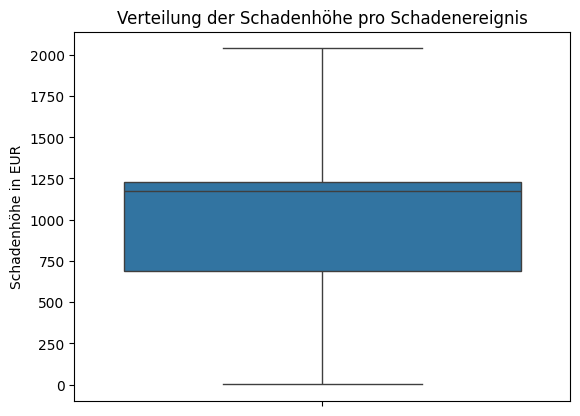

In [29]:
sns.boxplot(df_sev["claimamount"], showfliers = False)

plt.ylabel("Schadenhöhe in EUR")
plt.title("Verteilung der Schadenhöhe pro Schadenereignis")


(0.0, 5000.0)

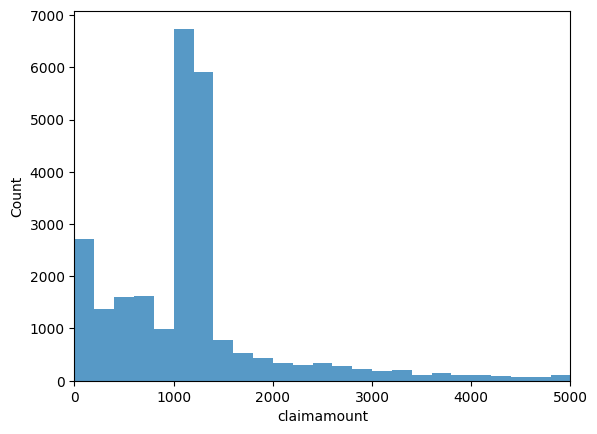

In [30]:
fig, ax = plt.subplots()
sns.histplot(df_sev["claimamount"],ax=ax, binwidth = 200)
ax.set_xlim(0,5000) # Dartellung bis ca. 95% Quantil

Ein großer Anteil der Schäden liegt unterhalb von ca. 1.500 EUR mit einer starken Konzentration zwischen 1.000-1.400 EUR.    
Des Weiteren gibt es einen hohen Anteil an Niedrigwertschäden (<200 EUR), vielleicht aufgrund von Bruchschäden an Rückspiegeln und Scheinwerfern.  
Der Bereich 400 - 800 EUR ist ebenfalls stärker ausgeprägt.

In [31]:
absrel_counts(df_sev, "claimamount").head(10)

,claimamount,Absolute Häufigkeit,Relative Häufigkeit in %
0,1204.00,"4,792",17.99
1,1128.12,"3,056",11.47
2,1172.00,"2,072",7.78
3,1128.00,831,3.12
4,602.00,433,1.63
5,1320.00,175,0.66
6,556.14,155,0.58
7,586.00,104,0.39
8,1500.00,103,0.39
9,564.06,94,0.35


Bestimmte Schadenhöhen kommen sehr häufig vor: 1.204, 1.128, 1.172. 
Hier müsste abgeklärt werden, inwiefern dies plausibel ist. Handelt es sich hierbei um Pauschalen, die bei einem Schaden gezahlt werden?

In [32]:
# Log-Transformation zur besseren Darstellung im Historgramm
df_sev['claimamount_log'] = np.log(df_sev['claimamount'])

(0.0, 15.0)

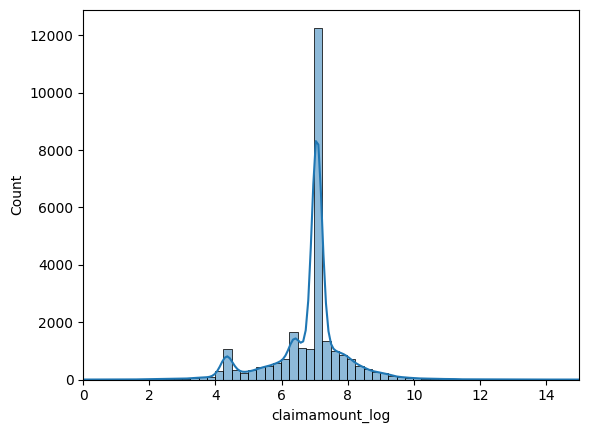

In [33]:
fig, ax = plt.subplots()
sns.histplot(df_sev["claimamount_log"],ax=ax, binwidth = 0.25, kde=True)
ax.set_xlim(0,15)

Prüfung auf Duplikate

In [34]:
# Überprüfung Duplikate ganze Reihe (individuelle ID-Schadenhöhe-Kombinationen)
df_sev.duplicated().value_counts()

False    26384
True       255
Name: count, dtype: int64

Es gibt 26.384 einzigartige ID-Schadenhöhe-Kombinationen.  
255 Einträge stammen von ID-Schadenhöhen-Kombinationen, die mehrfach auftauchen, d.h. die ID ist mit der selben Schadenhöhe mehr als einmal aufgeführt.  
Hier könnte eine mögliche Begründung sein, dass gewisse Schäden mehrfach aufgetreten sind und über Pauschalen abgerechnet werden.   
Es könnte aber auch sein, dass Werte fehlerhaft mehrfach aufgelistet wurden. 

In [35]:
# Überprüfung Duplikate in ID-Spalte (individuelle IDs)
df_sev.duplicated(subset = "idpol").value_counts()

False    24950
True      1689
Name: count, dtype: int64

Es gibt 24.950 einzigartige IDs.  
1.689 Einträge stammen von IDs, die mehrfach auftauchen, d.h. bei der Vertrags-ID gab es im Versicherungszeitraum mehrere Schäden. 

Im nächsten Schritt gruppieren wir die Schadenhöhen, sodass wir für jede Vertrags-ID die Summe aller Einzelschäden erhalten.  

In [36]:
# Gruppieren der Schadenhöhe
df_claimamount_by_id = df_sev.groupby("idpol")["claimamount"].sum().reset_index()

In [37]:
# Spalte umbenennen
df_claimamount_by_id.rename(columns={"claimamount":"total_claimamount"}, inplace = True)

Ebenfalls berechnen wir die Schadenanzahl pro Vertrags-ID, um diese dann mit `claimnb` aus dem anderen Datensatz zu vergleichen. 

In [38]:
# Anzahl Schäden
df_claim_nb_by_id = df_sev.groupby("idpol")["claimamount"].count().reset_index()

In [39]:
# Spalte umbenennen
df_claim_nb_by_id.rename(columns={"claimamount":"nb_claimamount"}, inplace = True)

In [40]:
# Verteilung der Schadenanzahl
absrel_counts(df_claim_nb_by_id,"nb_claimamount").sort_values("nb_claimamount")

,nb_claimamount,Absolute Häufigkeit,Relative Häufigkeit in %
0,1,"23,571",94.47
1,2,"1,298",5.2
2,3,62,0.25
3,4,5,0.02
4,5,2,0.01
6,6,1,0.0
9,8,1,0.0
11,9,1,0.0
5,11,2,0.01
10,16,1,0.0


Ein Blick auf die Schadenanzahl zeigt uns, dass in den meisten Fällen 1 Schaden pro ID vorliegt.

#### Zusammenführen der Dataframes

In [41]:
# Merge DataFrames mit Schadenhöhe und Schadenanzahl pro ID
df_sev_grouped = pd.merge(df_claimamount_by_id,df_claim_nb_by_id, on="idpol", how = "left")

In [42]:
df_sev_grouped

,idpol,total_claimamount,nb_claimamount
0,139,303.00,1
1,190,1981.84,1
2,414,1456.55,1
3,424,10834.00,2
4,463,3986.67,1
...,...,...,...
24945,6113521,1324.40,1
24946,6113793,1769.88,1
24947,6113817,1288.28,1
24948,6113834,12230.40,2


In [43]:
# Zusammenführen beider Datensätze
df_merged = pd.merge(df_freq,df_sev_grouped, on="idpol", how = "left")

In [44]:
# Neuer DataFrame 
df_merged

,idpol,claimnb,exposure,area,vehpower,vehage,drivage,bonusmalus,vehbrand,vehgas,density,region,total_claimamount,nb_claimamount
0,1,1,0.10000,D,5,0,55,50,B12,Regular,1217,R82,NaN,NaN
1,3,1,0.77000,D,5,0,55,50,B12,Regular,1217,R82,NaN,NaN
2,5,1,0.75000,B,6,2,52,50,B12,Diesel,54,R22,NaN,NaN
3,10,1,0.09000,B,7,0,46,50,B12,Diesel,76,R72,NaN,NaN
4,11,1,0.84000,B,7,0,46,50,B12,Diesel,76,R72,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326,0,0.00274,E,4,0,54,50,B12,Regular,3317,R93,NaN,NaN
678009,6114327,0,0.00274,E,4,0,41,95,B12,Regular,9850,R11,NaN,NaN
678010,6114328,0,0.00274,D,6,2,45,50,B12,Diesel,1323,R82,NaN,NaN
678011,6114329,0,0.00274,B,4,0,60,50,B12,Regular,95,R26,NaN,NaN


Es wird angenommen, dass alle IDs, die keine Infos zum `ClaimAmount` haben, im Versicherungszeitraum keinen Schaden hatten.

In [45]:
# Ersetze alle NaN mit 0
df_merged.fillna({"total_claimamount": 0}, inplace = True)
df_merged.fillna({"nb_claimamount": 0}, inplace = True)

In [46]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   idpol              678013 non-null  int64  
 1   claimnb            678013 non-null  int64  
 2   exposure           678013 non-null  float64
 3   area               678013 non-null  object 
 4   vehpower           678013 non-null  int64  
 5   vehage             678013 non-null  int64  
 6   drivage            678013 non-null  int64  
 7   bonusmalus         678013 non-null  int64  
 8   vehbrand           678013 non-null  object 
 9   vehgas             678013 non-null  object 
 10  density            678013 non-null  int64  
 11  region             678013 non-null  object 
 12  total_claimamount  678013 non-null  float64
 13  nb_claimamount     678013 non-null  float64
dtypes: float64(3), int64(7), object(4)
memory usage: 72.4+ MB


Wir wandeln noch den Datentyp von `nb_claimamount` in integer um.

In [47]:
# Anwendung des Integer-Checks auf die Spalte mit den IDs 
column_integer_check(df_merged, "nb_claimamount")

True

In [48]:
# Umwandlung in integer-Type
df_merged["nb_claimamount"] = df_merged["nb_claimamount"].astype(int)

Die Anzahl Schäden scheint bei einigen IDs nicht übereinzustimmen, wenn man den Wert aus der einen Datenbasis mit der anderen vergleicht. Daher wir eine zusätzliche Variable (boolean) erstellt, um dies weiter zu untersuchen. Diese Variable hat den Wert `false`, wenn die Werte unterschiedlich sind.  

In [49]:
# Erstellen neuer Variablen zur Überprüfung der Anzahl Schäden
df_merged["claimnb_check"] = df_merged["claimnb"] == df_merged["nb_claimamount"]

In [50]:
absrel_counts(df_merged, "claimnb_check")

,claimnb_check,Absolute Häufigkeit,Relative Häufigkeit in %
0,True,"668,896",98.66
1,False,"9,117",1.34


Bei 1,3% der IDs gibt es Inkonsistenzen bei der Anzahl an Schäden. Da dies marginal ist, löschen wir die betroffenen Reihen.

In [51]:
# Löschen aller IDs mit Inkonsistenzen bei Schadenanzahl
df_merged_drop = df_merged[df_merged["claimnb_check"]==True]

In [52]:
# Löschen der Spalten, die nicht mehr benötigt werden
df_merged_drop = df_merged_drop.drop(columns=["claimnb_check", "nb_claimamount"], axis=1)

Als nächstes erstellen wir unsere **Zielvariable**, die wir mit unserem Modell schätzen wollen - die **jährliche Schadenhöhe**. Diese berechnen wir wie in der Aufgabenstellung beschrieben aus der Summe der Schadenhöhe geteilt durch den Versicherungszeitraum (`exposure`).  
   
Einen Eindruck von der Verteilung der Schäden haben wir oben bereits erhalten. Dies wird sich auch nach unserem Data Cleaning und der Aggregation der Schäden nicht geändert haben. 
Um ein Bild von der `exposure` zu Erhalten, erstellen wir folgenden Plot.


<Axes: xlabel='exposure', ylabel='Count'>

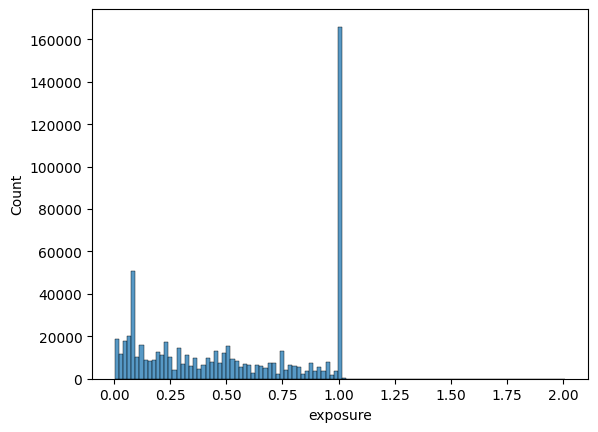

In [53]:
fig, ax = plt.subplots()
sns.histplot(df_merged_drop["exposure"],ax=ax)

Es wird deutlich, dass sich die Daten diesbezüglich in 2 Gruppen einteilen lassen: 
- IDs mit einer Laufzeit von 1 Jahr  
- IDs mit einer Laufzeit < 1 Jahr.
   
Dazu wollen wir uns noch die Anteile in % errechnen.

In [54]:
# Anteil der IDs mit einer Laufzeit < 1 Jahr
df_merged_drop[df_merged_drop["exposure"] < 1].idpol.count()/(df_merged_drop.shape[0])

0.7504230852030809

In [55]:
# Anteil der IDs mit einer Laufzeit = 1 Jahr
df_merged_drop[df_merged_drop["exposure"] == 1].idpol.count()/(df_merged_drop.shape[0])

0.24774703391857628

Ca. 25% der KfZ-Verträge haben eine Laufzeit von einem Jahr und 75% eine kürzere Laufzeit.

Da wir nun beide Bestandteile der Zielvariablen kennen, generieren wir die Zielvariable.

In [56]:
# Erstellen der Zielvariablen
df_merged_drop["claimamount_year"] = (df_merged_drop["total_claimamount"]/df_merged_drop["exposure"]).round(2)

An dieser Stelle sei angemerkt, dass die Schadenhöhe pro Jahr durch lineare Extrapolation errechnet wird, was durchaus kritisch zu betrachten ist, weil es eine sehr starke Annahme ist mit starker Auswirkung auf die Schadenhöhe.   
Dadruch unterstellen wir, dass die Schäden eines Versicherungsnehmers mit z.B. einem Monat Laufzeit sich in den folgenden Monaten in gleicher Höhe fortsetzen. Das führt zu einem Aufblähen der Schadenhöhe, wie das folgende Beispiel zeigen soll mit Hinblick auf die Werte der letzten beiden Spalten.    
Dennoch wissen wir bereits, dass die meisten KfZ-Verträge mit Schaden "nur" einen Schaden haben, was die Tabelle unten erneut bestätigt (bei der Analyse für Versicherungen mit einer Laufzeit von einem Jahr). Es ist also relativ unwahrscheinlich, dass der Versicherungsnehmer 12 Schäden verursacht, wenn er im ersten Monat einen Schaden hatte.   

Alternativ könnte man zukünftig nur die IDs mit einem Versicherungszeitraum von genau einem Jahr behalten. Das würde allerdings zu einem deutlichen Verlust von Daten führen. Wir entscheiden uns an dieser Stelle dagegen. 

In [57]:
# Beispiele für Versicherungen mit Laufzeit kürzer als 1 Monat
df_merged_drop[(df_merged_drop["exposure"]<(30/365)) & (df_merged_drop["claimnb"]>0)].head(3)

,idpol,claimnb,exposure,area,vehpower,vehage,drivage,bonusmalus,vehbrand,vehgas,density,region,total_claimamount,claimamount_year
627,1301,1,0.05,D,6,0,76,50,B12,Regular,543,R91,4573.47,91469.4
1258,2606,1,0.01,E,7,0,45,60,B12,Diesel,6570,R11,1322.75,132275.0
2514,5244,1,0.01,A,12,4,69,50,B12,Diesel,7,R93,5340.29,534029.0


In [58]:
# Anzahl Schäden für Versicherungen mit einem Jahr Laufzeit
absrel_counts(df_merged_drop[(df_merged_drop["exposure"] == 1) & (df_merged_drop["claimnb"]>0)],"claimnb")

,claimnb,Absolute Häufigkeit,Relative Häufigkeit in %
0,1,"8,403",95.46
1,2,389,4.42
2,3,10,0.11
3,5,1,0.01


In [59]:
df_merged_drop

,idpol,claimnb,exposure,area,vehpower,vehage,drivage,bonusmalus,vehbrand,vehgas,density,region,total_claimamount,claimamount_year
66,139,1,0.75000,F,7,1,61,50,B12,Regular,27000,R11,303.00,404.00
93,190,1,0.14000,B,12,5,50,60,B12,Diesel,56,R25,1981.84,14156.00
199,414,1,0.14000,E,4,0,36,85,B12,Regular,4792,R11,1456.55,10403.93
205,424,2,0.62000,F,10,0,51,100,B12,Regular,27000,R11,10834.00,17474.19
223,463,1,0.31000,A,5,0,45,50,B12,Regular,12,R73,3986.67,12860.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326,0,0.00274,E,4,0,54,50,B12,Regular,3317,R93,0.00,0.00
678009,6114327,0,0.00274,E,4,0,41,95,B12,Regular,9850,R11,0.00,0.00
678010,6114328,0,0.00274,D,6,2,45,50,B12,Diesel,1323,R82,0.00,0.00
678011,6114329,0,0.00274,B,4,0,60,50,B12,Regular,95,R26,0.00,0.00


Für die weitere Bearbeitung überprüfen wir das Verhältnis von KfZ-Verträgen mit Schaden und ohne Schaden. Dafür erstellen wir eine binäre Variable mit dem Wert 1 im Schadenfall und 0 falls kein Schaden vorliegt.

In [60]:
# Erstellung katogorischer Variablen für Schadenfall
df_merged_drop["claim"] = np.where(df_merged_drop["claimnb"] > 0, 1, 0)


Text(0.5, 1.0, 'KfZ-Verträge mit und ohne Schaden')

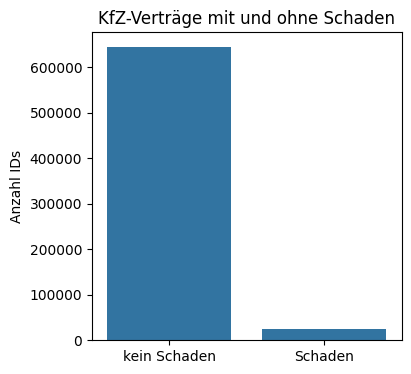

In [61]:
fig, ax = plt.subplots(figsize = (4,4))
sns.countplot(df_merged_drop, x="claim")

plt.xticks(ticks=[0,1], labels=['kein Schaden','Schaden'])
plt.ylabel("Anzahl IDs")
plt.xlabel("")
plt.title("KfZ-Verträge mit und ohne Schaden")

Wie wir bereits vermuten konnten gibt es im Datensatz ein starkes Ungleichgewicht zwischen den Verträgen mit und ohne Schaden. Da wir das Ziel haben, die Schadenhöhe pro Versicherungs-ID zu bestimmen (Regressionsproblem), der Anteil der Fälle mit einer Schadenhöhe > 0 aber marginal ist, können wir nicht direkt ein Modell mit dem Datensatz in der aktuellen Form aufsetzen.  

Ein Lösungsansatz wäre hier in 2 Schritten vorzugehen:  

**1. Modell: Klassifikation (binäre Zielvariable)**  
Schätzung der Wahrscheinlichkeit, ob ein Vertrag einen Schaden verursacht oder nicht (abhängige Variable: `claim`)

**2. Modell: Regression**  
Für die Fälle, bei denen ein Schaden vorhergesagt wird (`claim = 1`), wird die Schadenhöhe geschätzt (abhängige Variable: `claimamount_year`).

Zur Vereinfachung konzentrieren wir uns im Folgenden auf den Aufbau des 2. Modells. Dafür betrachten wir ausschließlich die Daten mit einem Schaden. 

In [62]:
# Löschen aller Zeilen ohne Schaden
df_final = df_merged_drop[df_merged_drop["claim"] == 1]

In [63]:
# Löschen der Spalten, die nicht mehr benötigt werden
df_final = df_final.drop(columns=["claim"], axis=1).reset_index()

In [64]:
df_final

,index,idpol,claimnb,exposure,area,vehpower,vehage,drivage,bonusmalus,vehbrand,vehgas,density,region,total_claimamount,claimamount_year
0,66,139,1,0.75,F,7,1,61,50,B12,Regular,27000,R11,303.00,404.00
1,93,190,1,0.14,B,12,5,50,60,B12,Diesel,56,R25,1981.84,14156.00
2,199,414,1,0.14,E,4,0,36,85,B12,Regular,4792,R11,1456.55,10403.93
3,205,424,2,0.62,F,10,0,51,100,B12,Regular,27000,R11,10834.00,17474.19
4,223,463,1,0.31,A,5,0,45,50,B12,Regular,12,R73,3986.67,12860.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24938,677203,6113521,1,0.18,C,4,1,26,60,B12,Diesel,311,R82,1324.40,7357.78
24939,677475,6113793,1,0.14,C,7,2,51,50,B12,Diesel,178,R72,1769.88,12642.00
24940,677499,6113817,1,0.17,D,4,0,35,51,B12,Regular,1719,R82,1288.28,7578.12
24941,677516,6113834,2,0.17,C,15,3,36,50,B12,Regular,181,R54,12230.40,71943.53


In [65]:
df_final.shape

(24943, 15)

Insgesamt verbleiben ca. 25.000 Vertrags-IDs.

## 3. Explorative Datenanalyse

Nun schauen wir uns die einzelnen Variablen aus unserem finalen Dataframe nochmal genauer an und erstellen verschiedene Plots, um mehr Informationen zu Verteilung zu erhalten und ebenfalls eventuelle Ausreißer zu identifizieren und auszuschließen.

In [66]:
df_final.describe()

,index,idpol,claimnb,exposure,vehpower,vehage,drivage,bonusmalus,density,total_claimamount,claimamount_year
count,24943.000000,2.494300e+04,24943.000000,24943.000000,24943.000000,24943.000000,24943.000000,24943.000000,24943.000000,2.494300e+04,2.494300e+04
mean,296747.429058,2.262482e+06,1.060137,0.692664,6.468909,7.386481,45.140721,64.928958,1984.332438,2.401823e+03,1.041796e+04
std,193375.998759,1.578461e+06,0.289874,0.313974,2.012865,5.173566,14.658049,19.864205,4119.800061,3.026536e+04,1.917027e+05
min,66.000000,1.390000e+02,1.000000,0.002740,4.000000,0.000000,18.000000,50.000000,2.000000,1.000000e+00,1.000000e+00
25%,128728.500000,1.082674e+06,1.000000,0.450000,5.000000,3.000000,34.000000,50.000000,111.000000,7.498350e+02,1.128000e+03
50%,265225.000000,2.130093e+06,1.000000,0.760000,6.000000,7.000000,45.000000,55.000000,495.000000,1.172000e+03,1.504160e+03
75%,451617.500000,3.178466e+06,1.000000,1.000000,7.000000,11.000000,54.000000,76.000000,2120.000000,1.346400e+03,3.352390e+03
max,677653.000000,6.113971e+06,16.000000,2.000000,15.000000,99.000000,99.000000,228.000000,27000.000000,4.075401e+06,1.852455e+07


### Schadenaufwand pro Jahr: `claimamount_year` 

Wir werfen erneut einen Blick auf die Schadenhöhen. Zu Beginn hatten wir uns bereits die einzelnen Schadenhöhen pro Schadenereignis angeschaut. Jetzt schauen wir uns die aufsummierten Schadenhöhen pro ID pro Jahr an.  
Um zu bestimmen ab welcher Grenze wir Ausreißer ausschließen, betrachten wir verschieden Quantile genauer. 

Die jährlichen Schadenaufwendungen liegen zwischen 1 und 18,5 Mio. EUR.  
Der Median liegt bei  1,5 T EUR und das 95%-Quantil bei ca. 19T EUR.


Text(0.5, 1.0, 'Verteilung der jährl. Schadenhöhe')

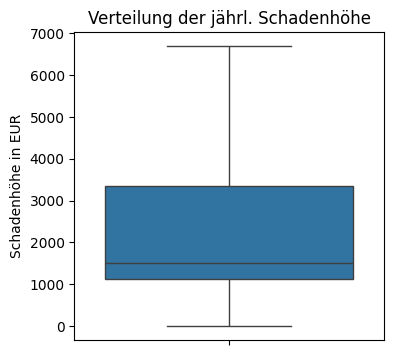

In [67]:
fig, ax = plt.subplots(figsize=(4,4))
sns.boxplot(df_final["claimamount_year"], showfliers = False, ax=ax)
plt.ylabel("Schadenhöhe in EUR")
plt.title("Verteilung der jährl. Schadenhöhe")

In [68]:
# Q1, Q3 und IQR
q1_claimamount_year = df_final["claimamount_year"].quantile(0.25)
q3_claimamount_year = df_final["claimamount_year"].quantile(0.75)
iqr_claimamount_year = q3_claimamount_year - q1_claimamount_year

In [69]:
# Mögliche Grenze für Ausschluss von Ausreißern
outlier_claimamount_year = q3_claimamount_year+(1.5*iqr_claimamount_year)
print(outlier_claimamount_year)

6688.975


In [70]:
# Obere Quantile der Schadenhöhen
quantils = [0.95, 0.975, 0.99]
quantile_values = [round(df_final["claimamount_year"].quantile(i),2) for i in quantils]
print(quantile_values)

[18910.7, 38554.29, 110893.71]


Text(0.5, 1.0, 'Verteilung der jährichen Schadenhöhe')

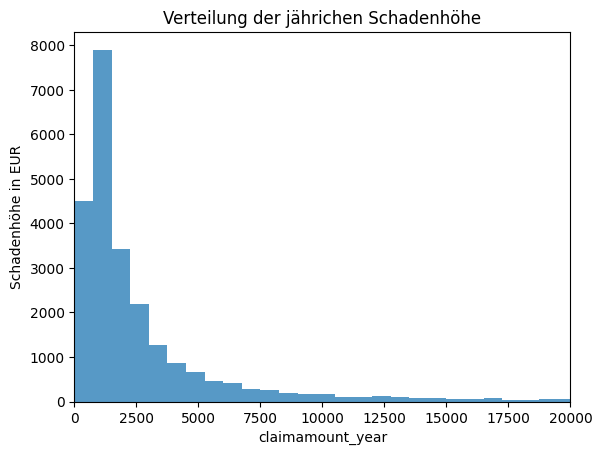

In [71]:
fig, ax = plt.subplots()
sns.histplot(df_final["claimamount_year"],ax=ax, binwidth = 750)
ax.set_xlim(0,20000)
plt.ylabel("Schadenhöhe in EUR")
plt.title("Verteilung der jährichen Schadenhöhe")

Da die Verteilung sehr rechtsschief ist und es einige sehr hohe Ausreißer gibt, wollen wir diese eliminieren, bevor wir weitermachen. Ausreißer können insbesondere bei linearen Regressionsmodelle zu einer starken Verzerrung führen.  

Ein übliches Verfahren zur Abgrenzung von Ausreißern ist die Grenze: Q3 + IQR x 0.5.  
Wir berechnen nun wie hoch der Anteil der Daten wäre, die dann ausgeschlossen werden würden.

In [72]:
# Anteil der Daten
df_final[df_final["claimamount_year"] > outlier_claimamount_year].idpol.count()/df_final.shape[0]

0.13218137353165216

Ein Ausschluss von 13% der Daten erscheint uns recht hoch. Dennoch entscheiden wir uns dafür, da wir sonst befürchten, dass es bei unserem Modell später zu Verzerrungen durch hohe Werte kommen könnte.

Somit behalten wir alle Daten, die eine jährliche Schadenhöhe < 13.378 EUR haben.

In [73]:
# Entfernen von Ausreißern
df_final = df_final[df_final["claimamount_year"] < outlier_claimamount_year]

### Kategorische Variablen: `area`, `vehbrand`, `vegas`, `region`

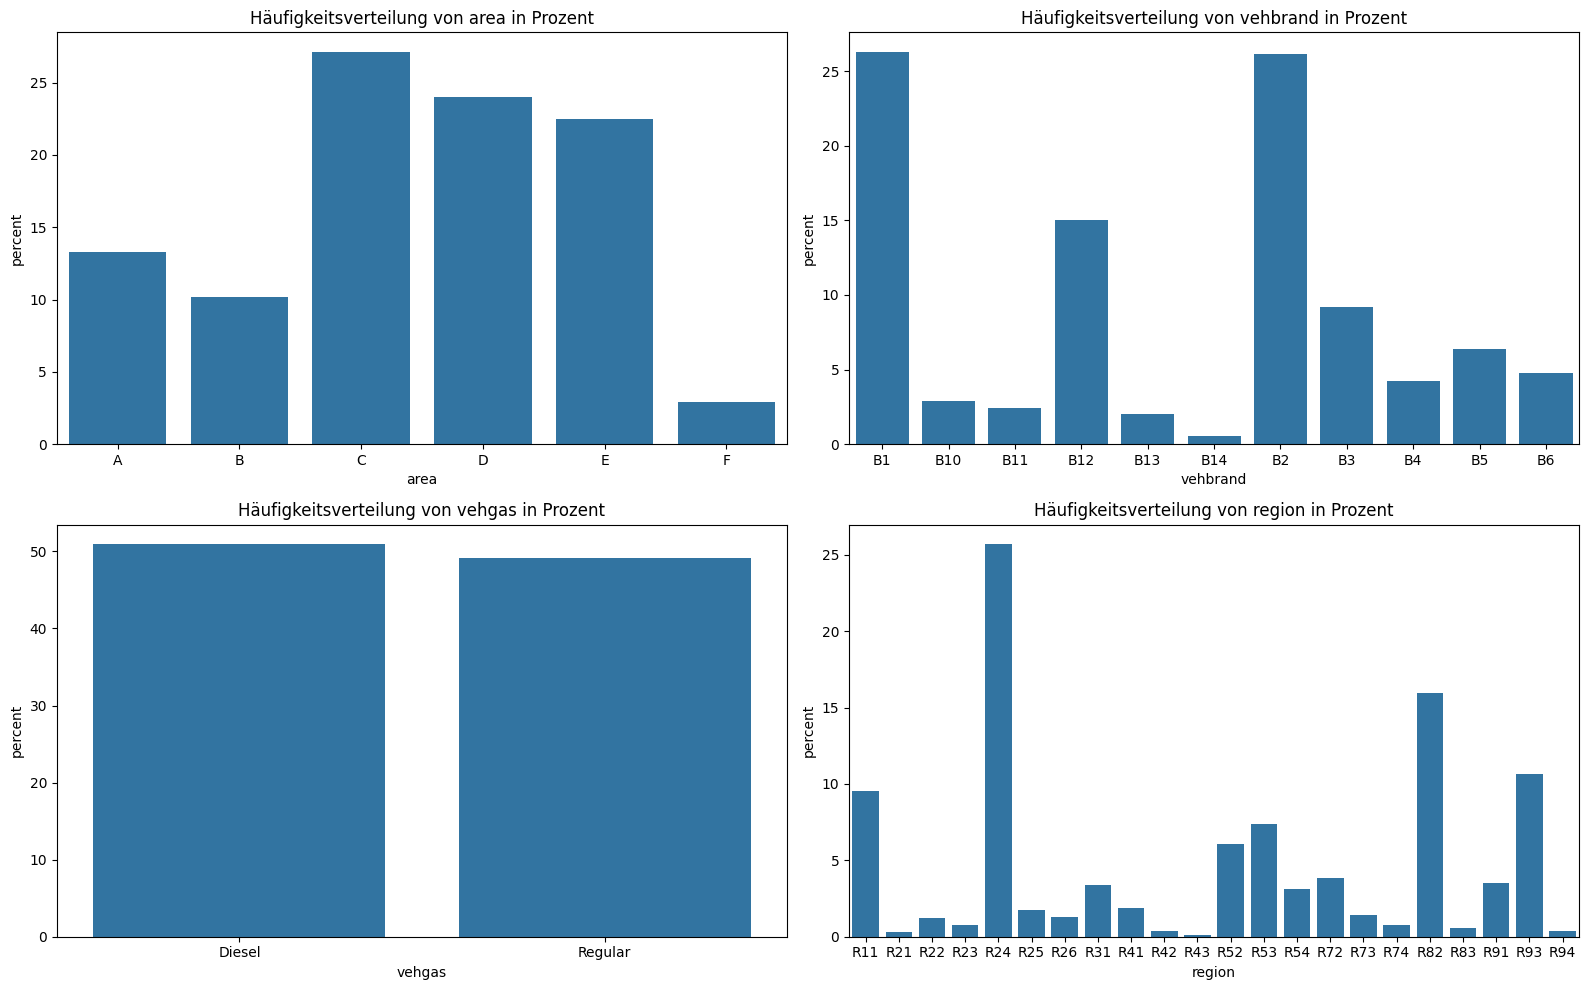

In [74]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
for xcol, ax in zip(['area', 'vehbrand', 'vehgas', 'region'], axes.flatten()):
    sns.countplot(data=df_final.sort_values(xcol), x=xcol, ax=ax, stat="percent")
    ax.set_title(f"Häufigkeitsverteilung von {xcol} in Prozent")
    
plt.tight_layout()
plt.show()
    


Kategorien mit geringer Häufigkeit würde man in eine Restkategorie zusammenfassen. Zur Vereinfachung wurde dieser Schritt an dieser Stelle ausgelassen. 

### Numerische Variablen: `vehpower`, `vehage`, `drivage`, `bonusmalus`, `density`

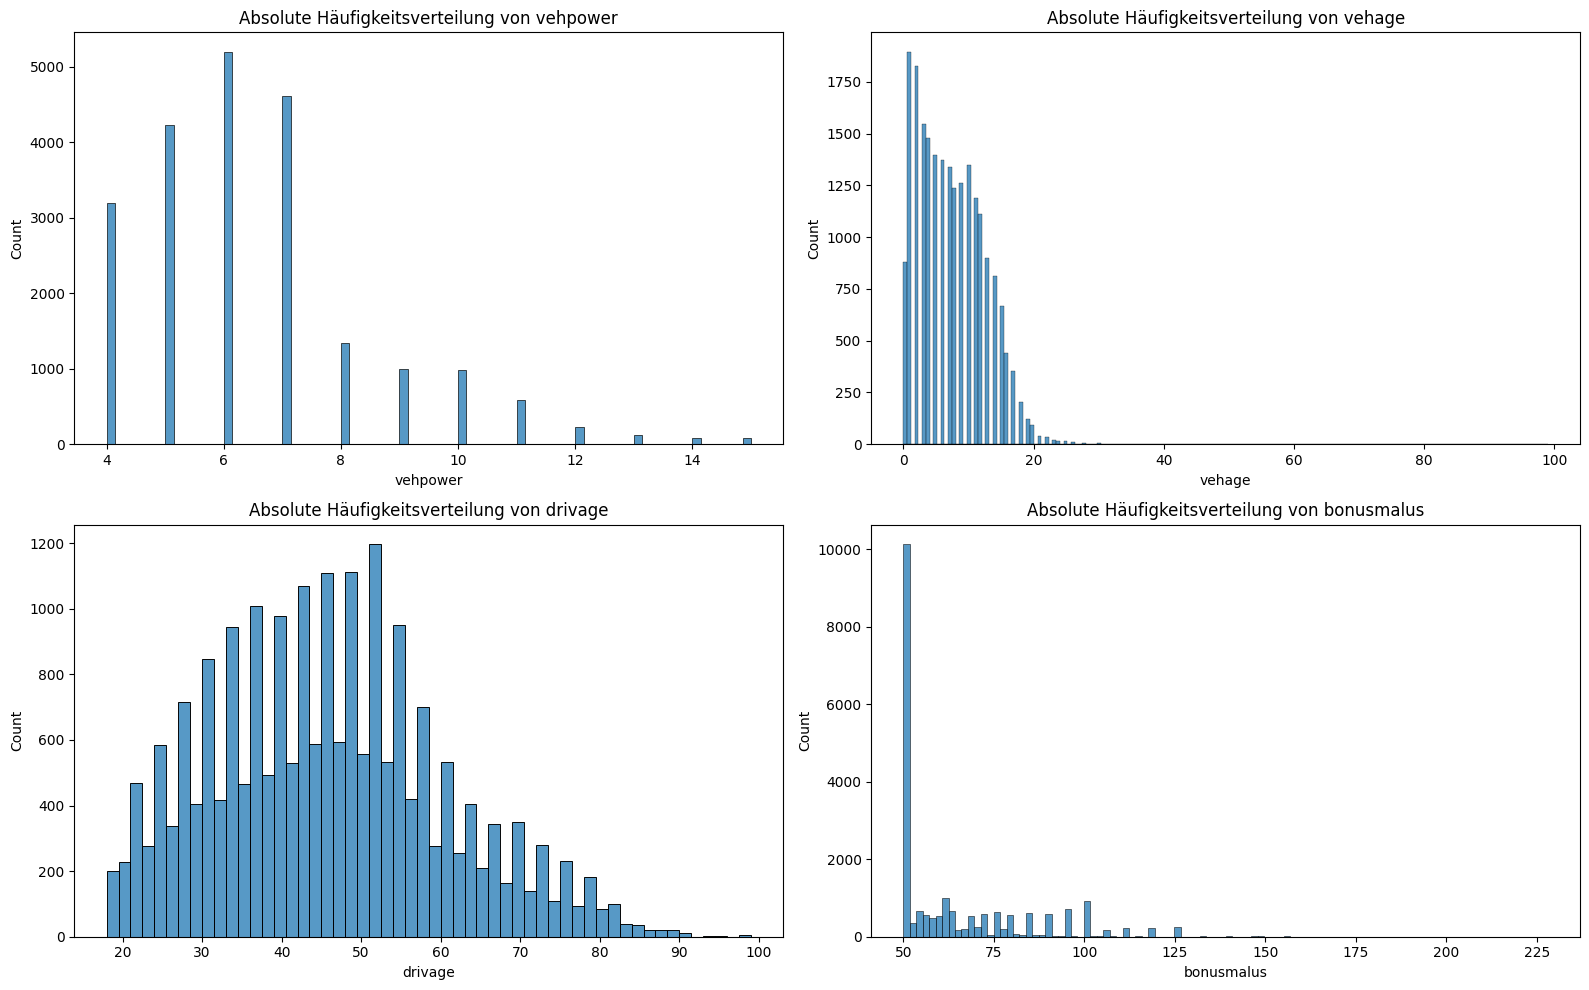

In [75]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
for xcol, ax in zip(['vehpower', 'vehage', 'drivage', 'bonusmalus'], axes.flatten()):
    sns.histplot(df_final[xcol],ax=ax)
    ax.set_title(f"Absolute Häufigkeitsverteilung von {xcol}")
    
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Absolute Häufigkeitsverteilung von density')

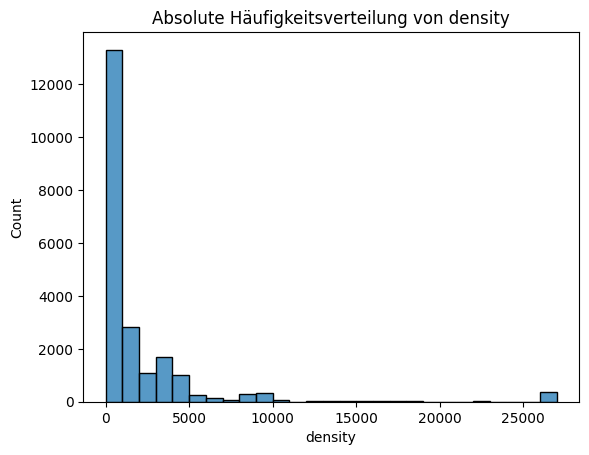

In [76]:
fig, ax = plt.subplots()
sns.histplot(df_final["density"],ax=ax, binwidth=1000)
ax.set_title(f"Absolute Häufigkeitsverteilung von density")

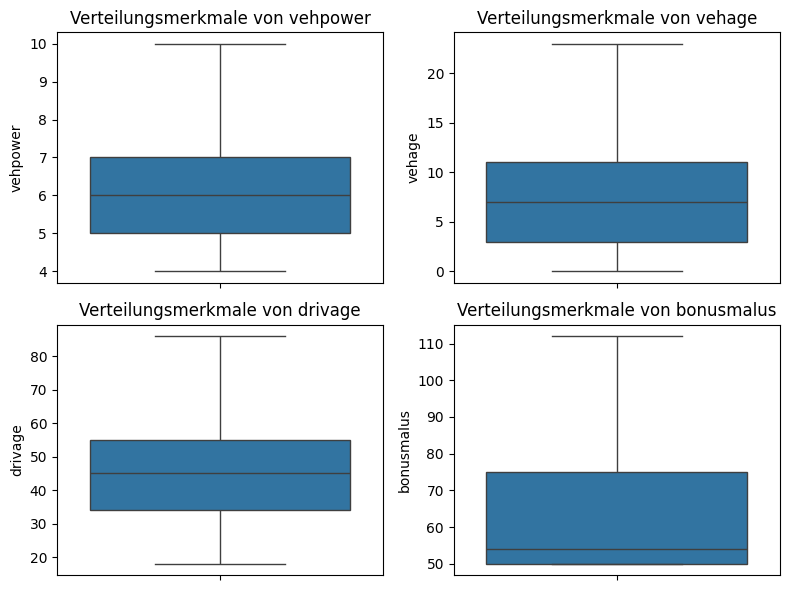

In [77]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
for xcol, ax in zip(['vehpower', 'vehage', 'drivage', 'bonusmalus', 'density'], axes.flatten()):
    sns.boxplot(df_final[xcol], showfliers = False, ax=ax)
    ax.set_title(f"Verteilungsmerkmale von {xcol}")
    
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Verteilungsmerkmale von density')

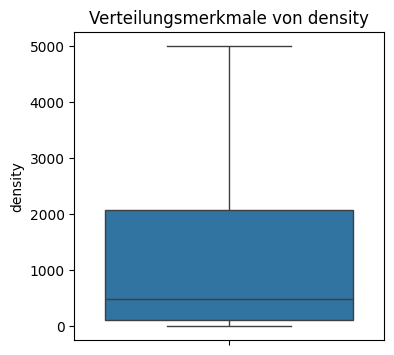

In [78]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.boxplot(df_final["density"], showfliers = False, ax=ax)
ax.set_title(f"Verteilungsmerkmale von density")

Bei `vehage` gibt es einige hohe Werte mit sehr geringer Häufigkeit. Wir schauen uns die oberen Werte nochmal genauer an.

In [79]:
absrel_counts(df_final, "vehage").sort_values("vehage", ascending = False)

,vehage,Absolute Häufigkeit,Relative Häufigkeit in %
37,99,1,0.0
39,84,1,0.0
38,69,1,0.0
33,39,2,0.01
30,36,3,0.01
31,35,3,0.01
32,33,2,0.01
36,32,2,0.01
34,31,2,0.01
28,30,6,0.03


Wir sehen, dass oberhalb von ca. einem KfZ-Alter von 20 sehr wenig Beobachtungen vorhanden sind (<50 IDs pro Ausprägung).

Die Verteilung von `density` verhält sich recht speziell, da die Verteilung rechtsschief /linksteil ist, allerdings am oberen Rand der Verteilung nochmal ein deutlicher Anstieg der Häufigkeit zu beobachten ist. Auch hier werfen wir einen Blick auf die oberen Ausprägungen.

In [80]:
absrel_counts(df_final, "density").sort_values("density", ascending = False).head(20)

,density,Absolute Häufigkeit,Relative Häufigkeit in %
0,27000,376,1.74
718,23396,5,0.02
940,22821,3,0.01
305,22669,18,0.08
742,21410,5,0.02
524,18229,9,0.04
143,17140,38,0.18
287,16533,19,0.09
506,16291,9,0.04
1072,16284,2,0.01


Interessanterweise gibt es bei einer Bevölkerungsdichte von 27T Einwohner pro km² nochmal einen Anstieg von Beobachtungen. 

Bei den Features gibt es einige Ausreißer. Wir beschließen folgende Verträge auszuschließen: 
- mit einem KfZ-Alter > 20,
- mit BonusMalus > 125,
- mit einem Alter des KfZ-Halters > 82

Bei `density` schließen wir bewusst keine höheren Werte aus, da der höchste Wert kein Ausreißer zu sein scheint. Zudem wäre es durchaus plausibel, dass wenn der Wohnort im Zentrum einer Metropole liegt, es ggf. häufiger Schäden gibt und wir wollen diese Information nicht verlieren. 

In [81]:
# Entfernen von Ausreißern
df_final = df_final[df_final["vehage"] <= 20]
df_final = df_final[df_final["drivage"] <= 82]
df_final = df_final[df_final["bonusmalus"] <= 127]

In [82]:
df_final.shape

(21215, 15)

### 4. Feature Engineering

#### Log-Transformation der abhängigen Variablen

Da wir bereits gesehen haben, dass die Verteilung sehr rechtsschief ist, könnte es sinnvoll sein, die abhängige Variable zu logarithmieren. 

In [83]:
# Log-Transformation der abhängigen Variablen
df_final["claimamount_year_log"] = np.log(df_final["claimamount_year"])

(0.0, 15.0)

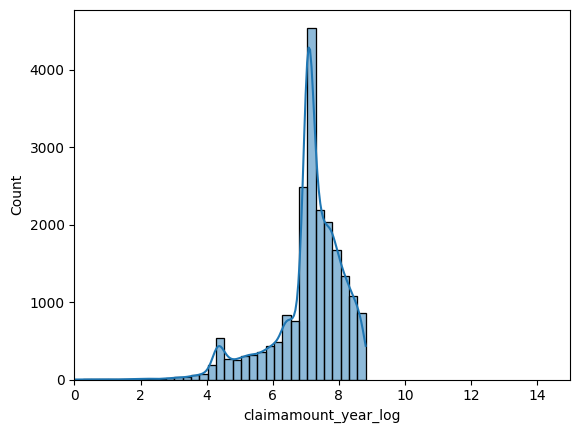

In [84]:
fig, ax = plt.subplots()
sns.histplot(df_final["claimamount_year_log"],ax=ax, binwidth = 0.25, kde=True)
ax.set_xlim(0,15)


#### One-hot Encoding der kategorischen unabhängigen Variablen

Im Hinblick auf unser lineares Regressionsmodell ist es wichtig, dass wir die kategorischen Variablen one-hot-encoden, d.h. wir erstellen pro Ausprägung eine eigene Dummy-Variable, die im Fall des Eintretens den Wert 1 annimmt oder ansonsten den Wert 0 annimmt.  

Um das Problem der Multikolinearität bei linearen Regressionsmodellen zu vermeiden, dürfen wir jedoch nicht alle Dummy-Variablen in das Modell reinnehmen. Später werden wir noch Dummy-Variablen entfernen.  


In [85]:
# Erstellung der Dummy-Variablen 
area_dummies = pd.get_dummies(df_final["area"], prefix = "ar").astype("int")
vehbrand_dummies = pd.get_dummies(df_final["vehbrand"]).astype("int")
vehgas_dummies = pd.get_dummies(df_final["vehgas"], drop_first = True).astype("int")
region_dummies = pd.get_dummies(df_final["region"]).astype("int")   

In [86]:
# Zusammenführen der Dataframes
df_final = pd.concat([df_final,area_dummies], axis = 1)
df_final = pd.concat([df_final,vehbrand_dummies], axis = 1)
df_final = pd.concat([df_final,vehgas_dummies], axis = 1)
df_final = pd.concat([df_final,region_dummies], axis = 1)

In [87]:
# Löschen der ursprünglichen kategorischen Variablen
df_final = df_final.drop(['area','vehbrand','vehgas', 'region'], axis=1)

In [88]:
df_final.head(10)

,index,idpol,claimnb,exposure,vehpower,vehage,drivage,bonusmalus,density,total_claimamount,claimamount_year,claimamount_year_log,ar_A,ar_B,ar_C,ar_D,ar_E,ar_F,B1,B10,B11,B12,B13,B14,B2,...,B5,B6,Regular,R11,R21,R22,R23,R24,R25,R26,R31,R41,R42,R43,R52,R53,R54,R72,R73,R74,R82,R83,R91,R93,R94
0,66,139,1,0.75,7,1,61,50,27000,303.00,404.00,6.001415,0,0,0,0,0,1,0,0,0,1,0,0,0,...,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,287,606,1,0.84,10,6,54,50,583,1840.14,2190.64,7.691949,0,0,0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6,295,622,1,0.75,5,0,34,64,1565,1397.97,1863.96,7.530459,0,0,0,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,388,811,1,0.76,5,0,44,50,3317,971.98,1278.92,7.153771,0,0,0,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
8,396,830,1,0.68,4,10,24,105,3064,1442.75,2121.69,7.659968,0,0,0,0,1,0,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,468,975,1,0.73,9,0,60,50,570,637.41,873.16,6.772119,0,0,0,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
10,587,1226,1,0.79,7,7,28,80,65,3048.98,3859.47,8.258285,0,1,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,638,1323,1,0.62,8,4,67,72,2674,384.77,620.60,6.430687,0,0,0,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
13,650,1349,1,0.36,5,0,39,57,177,185.98,516.61,6.247288,0,0,1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
14,736,1534,1,0.62,4,0,47,50,79,671.05,1082.34,6.986881,0,1,0,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### 5. Modellierung

Im ersten Schritt würden wir eigentlich mit einem Baseline-Modell starten, welches uns als Referenzpunkt für unser Machine-Learning Modell dient. 
Als Baseline könnten wir z.B. ein heuristisches Modell wählen, was den Wert 1204 EUR als Schadenhöhe annimmt (dies war die am häufigsten vorkommende Schadenhöhe). Aus Zeitgründen verzichten wir jedoch auf das Baseline-Modell.

Für die Auswahl unseres Machine-Learning Modells ist es wichtig Modelle zu benutzen, welche nachvollziehbar und interpretierbar sind (white-box model). Am Ende wollen wir verstehen, welche Risikomerkmale einen Einfluss haben und wie hoch der Einfluss ist. 

Dafür kommen u.a. folgende Modelle in Frage: 
- lineare Regression
- Entscheidungsbaum
- KNN 

Aufgrund der einfachen Interpretation und der schnellen Umsetzbarkeit entscheiden wir uns im ersten Schritt für ein multivariates lineares Regressionsmodell.

Für ein lineares Regressionsmodell gelten folgende Annahmen: 
- Linearität der Parameter
- Erwartungswert der Störgrößen = Null
- Homoskedastizität: Die Residuen sollen die gleiche Varianz aufweisen.
- keine Autokorrelation des Fehlerterms
- Keine Multikollinearität: Keine lineare Abhängigkeit zwischen den unabhängigen Variablen
- Störgrößen (Residuen) sind normalverteilt

#### Auswahl von Features

Korrelation zwischen numerischen Variablen

<Axes: >

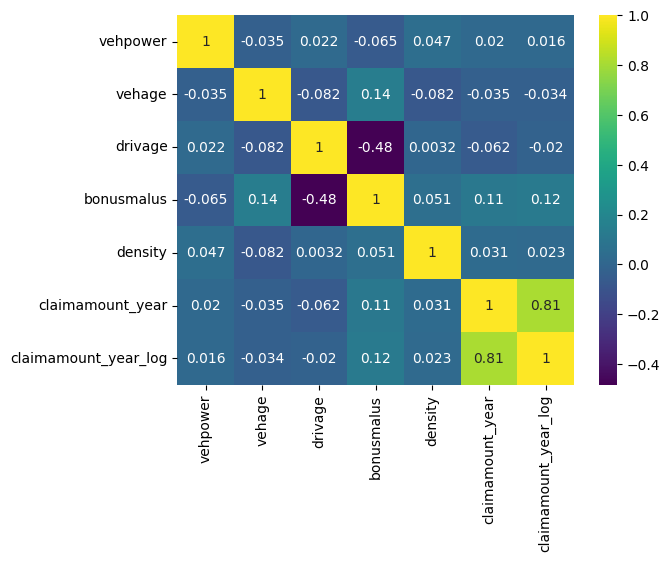

In [89]:
sns.heatmap(data=df_final[['vehpower', 'vehage', 'drivage', 'bonusmalus', 'density','claimamount_year','claimamount_year_log']].corr(), cmap = 'viridis', annot=True)

Es ist sehr überraschend zu sehen, dass wir kaum eine Korrelation zwischen den numerischen Variablen und der Schadenhöhe beobachten können. Dies ist grundsätzlich keine gute Grundvoraussetzung für den Aufbau eines linearen Regressionsmodells.  
Dennoch können wir beobachten, dass es einen leichte positiven Zusammenhang zwischen dem Schadenfreiheitsrabatt (`bonusmalus`) und der Schadenhöhe gibt.  
Ebenfalls sehen wir eine mittelstarke negative Korrelation zwischen dem Alter des Kfz-Halters und dessen Schadenfreiheitsrabatt. Die Beziehung beider Variablen ist nochmal im Scatterplot unten dargestellt. Eigentlich würde man hier einen positiven Zusammenhang erwarten. Hier müsste man weitere Informationen zum französischen System einholen, um den bonusmalus richtig interpretieren zu können. 

Text(0.5, 1.0, 'Zusammenhang zwischen Alter und Schadenfreiheitsrabatt')

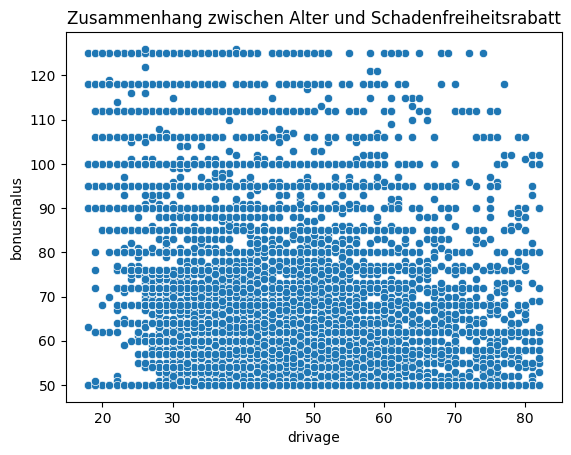

In [90]:
sns.scatterplot(data = df_final, x = "drivage", y = "bonusmalus")
plt.title(f"Zusammenhang zwischen Alter und Schadenfreiheitsrabatt")

Im nächsten Schritt wollen wir uns nochmal mit der Korrelation zwischen allen möglichen unabhängigen und der abhängigen Variable beschäftigen, um dann eine Auswahl an Features für das Modell zu treffen.

In [91]:
df_final_col_list_corr = df_final.columns.to_list()

In [92]:
col_to_remove = ['idpol',
                'claimnb',
                'exposure',
                'total_claimamount',
                'claimamount_year',
                'claimamount_year_log'
                ]

In [93]:
for col in col_to_remove:
    df_final_col_list_corr.remove(col)

In [94]:
df_final_col_list_corr.append('claimamount_year')
df_final_col_list_corr.append('claimamount_year_log')

In [95]:
df_final[df_final_col_list_corr].corr()

,index,vehpower,vehage,drivage,bonusmalus,density,ar_A,ar_B,ar_C,ar_D,ar_E,ar_F,B1,B10,B11,B12,B13,B14,B2,B3,B4,B5,B6,Regular,R11,R21,R22,R23,R24,R25,R26,R31,R41,R42,R43,R52,R53,R54,R72,R73,R74,R82,R83,R91,R93,R94,claimamount_year,claimamount_year_log
index,1.000000,0.062123,-0.065058,0.050550,-0.015301,0.056387,-0.017266,-0.017705,-0.011657,-0.007939,0.029790,0.043709,-0.086299,-0.008538,-0.005119,0.284402,-0.016384,-0.011923,-0.068143,-0.024905,-0.019747,-0.040374,-0.036785,-0.036229,0.097223,0.026618,0.005738,0.017417,-0.070045,-0.020626,0.017025,0.030149,-0.017737,-0.006453,0.016838,-0.041936,-0.037403,-0.018098,0.010566,0.039788,-0.013339,-0.031911,0.038818,0.028088,0.046986,0.033813,0.092760,0.114067
vehpower,0.062123,1.000000,-0.035434,0.021772,-0.064838,0.046784,-0.006663,-0.004988,-0.002032,-0.000338,-0.005779,0.043069,-0.077201,0.199715,0.173197,0.154461,0.092761,0.014813,-0.126502,-0.028412,-0.052113,-0.046080,-0.046872,-0.022507,0.046664,0.006727,0.004546,0.006362,-0.038516,-0.009225,-0.007417,-0.023980,-0.020409,-0.013108,-0.002991,-0.002378,-0.006307,0.001155,-0.011676,0.015232,0.000336,0.028839,0.013877,0.003043,0.002085,0.020662,0.019785,0.016300
vehage,-0.065058,-0.035434,1.000000,-0.082486,0.141253,-0.082042,0.050858,0.025917,-0.012651,0.011598,-0.027248,-0.077507,0.139913,0.021552,0.037786,-0.354772,0.006194,0.016918,0.113009,-0.008256,-0.013190,0.046686,-0.006918,0.113885,-0.106573,-0.025765,-0.019764,-0.021248,0.132359,0.012021,-0.006537,-0.028116,-0.005729,-0.010619,-0.017836,0.050178,0.014494,0.026497,-0.026749,-0.046152,0.011856,0.006873,-0.025002,-0.042893,-0.050047,-0.039855,-0.035202,-0.033535
drivage,0.050550,0.021772,-0.082486,1.000000,-0.482523,0.003203,0.030543,0.006940,0.021394,-0.029055,-0.029576,0.016753,-0.000124,0.030983,-0.027505,0.069970,0.017321,0.010910,0.036154,-0.092497,-0.036405,-0.023759,-0.023481,0.048509,-0.016861,-0.008589,-0.039979,-0.006930,0.009740,0.005975,-0.005119,-0.054728,0.048403,-0.005438,-0.024111,-0.017939,0.019982,-0.003335,0.004286,-0.002550,-0.000542,-0.000900,-0.000416,0.004422,0.030306,-0.001757,-0.061771,-0.020158
bonusmalus,-0.015301,-0.064838,0.141253,-0.482523,1.000000,0.051363,-0.038968,-0.029464,-0.056210,0.034640,0.069349,0.019893,0.009702,-0.038465,0.003660,-0.074412,-0.015141,-0.010664,0.012685,0.060817,0.006545,0.017231,0.011296,0.046246,0.035122,-0.007530,0.027647,-0.005481,0.016780,-0.006640,0.009710,0.029335,-0.040586,0.002810,0.006944,0.009277,-0.025680,0.015757,-0.008297,-0.015057,-0.003878,0.011889,-0.005450,-0.029828,-0.041299,-0.006314,0.110258,0.122623
density,0.056387,0.046784,-0.082042,0.003203,0.051363,1.000000,-0.183465,-0.154484,-0.254056,-0.120261,0.315083,0.844091,-0.043500,0.013323,0.001265,0.138170,0.008894,0.007317,-0.069827,0.008494,-0.013314,-0.013504,-0.002334,0.112386,0.554187,-0.015335,-0.025260,-0.015098,-0.200883,-0.040878,-0.041591,-0.019708,-0.033534,0.001876,-0.009782,-0.047129,-0.086101,-0.059344,-0.031799,-0.026609,-0.036063,0.048120,-0.018437,-0.054460,-0.001614,-0.021352,0.031240,0.023305
ar_A,-0.017266,-0.006663,0.050858,0.030543,-0.038968,-0.183465,1.000000,-0.131258,-0.238360,-0.219543,-0.210351,-0.067430,0.043370,-0.013487,-0.021752,-0.041759,-0.002067,-0.002492,0.044516,-0.019067,-0.016235,-0.020815,-0.016794,-0.079360,-0.115266,0.028731,0.001143,-0.000321,0.279186,0.006207,0.056263,-0.060690,-0.037548,-0.020381,0.013395,-0.032062,-0.060138,0.032681,0.016332,0.013023,0.079739,-0.106345,0.042943,-0.038380,-0.104431,0.023719,-0.031319,-0.021638
ar_B,-0.017705,-0.004988,0.025917,0.006940,-0.029464,-0.154484,-0.131258,1.000000,-0.205427,-0.189210,-0.181288,-0.058114,0.021866,-0.011096,-0.015330,-0.037848,-0.004310,-0.013099,0.036501,-0.011136,-0.011365,-0.003256,0.000249,-0.056065,-0.076144,0.001113,0.032423,0.006911,0.092139,0.027657,0.010523,-0.022412,-0.020061,-0.011580,-0.007631,0.028966,0.053609,0.027789,0.010251,0.017527,-0.018626,-0.063262,0.003754,-0.015996,-0.067937,-0.006515,-0.024711,-0.021832
ar_C,-0.011657,-

Wir betrachten nur die Korrelation mit claimamount_year_log (unterste Zeile in der Korrelationsmatrix) und identifizieren die Variablen mit sehr geringen Korrelationen und entfernen diese im nächsten Schritt.

In [96]:
df_final_col_list_m1 = df_final_col_list_corr.copy()

In [97]:
col_to_remove_m1 = [
                'ar_C',
                'B14',
                'B3',
                'B6',
                'Regular',
                'R22',
                'R41',
                'R42',
                'R54',
                'R74',
                'claimamount_year',
                'claimamount_year_log'
                ]

In [98]:
for col in col_to_remove_m1:
    df_final_col_list_m1.remove(col)

#### Vorbereitung der Trainings- & Testdaten

Im ersten Schritt nehmen wir die nicht log-transformierte abhängige Variable, da dies die Interpretation der Koeffizienten erleichtert und keine zusätzlichen Umwandlungsschritte nötig sind, um die Daten wieder auf die ursprüngliche Einheit zurückzubringen. 

In [99]:
# Dataframe für X (unabhängige Variablen)
X = df_final[df_final_col_list_m1]
X = sm.add_constant(X)

# Abhängige Variable
y = df_final['claimamount_year']

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

#### Lineares Regressionsmodell

In [100]:
sm.OLS(y_train, X_train).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       claimamount_year   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     19.62
Date:                Mon, 22 Apr 2024   Prob (F-statistic):          1.74e-122
Time:                        13:27:31   Log-Likelihood:            -1.4687e+05
No. Observations:               16972   AIC:                         2.938e+05
Df Residuals:                   16935   BIC:                         2.941e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1185.5970     94.513     12.544      0.000    1000.341    1370.853
index          0.0004    5.8e-05      7.528      0.000       0.000       0.001
vehpower       2.6736      5.684      0.470      0.638      -8.468      13.815
vehage        -2.0802      2.392     -0.870      0.385      -6.769       2.609
drivage       -1.2097      0.866     -1.398      0.162      -2.906       0.487
bonusmalus     8.4347      0.661     12.763      0.000       7.139       9.730
density       -0.0087      0.008     -1.149      0.250      -0.024       0.006
ar_A         -41.6538     36.972     -1.127      0.260    -114.122      30.814
ar_B         -45.5961     39.438     -1.156      0.248    -122.899      31.707
ar_D          46.3080     30.948      1.496      0.135     -14.353     106.969
ar_E          58.4099     44.494      1.313      0.189     -28.803     145.623
ar_F         187.8117    181.585      1.034      0.301    -168.113     543.737
B1          -100.8950     35.156     -2.870      0.004    -169.805     -31.985
B10         -105.0926     70.572     -1.489      0.136    -243.422      33.236
B11          -87.3502     75.130     -1.163      0.245    -234.613      59.912
B12          301.3820     42.512      7.089      0.000     218.053     384.711
B13         -148.4000     81.642     -1.818      0.069    -308.428      11.628
B2           -34.9540     35.133     -0.995      0.320    -103.818      33.910
B4           -75.1641     58.527     -1.284      0.199    -189.884      39.556
B5          -125.5175     50.298     -2.495      0.013    -224.106     -26.928
R11           13.0134     59.427      0.219      0.827    -103.469     129.496
R21          325.0864    193.739      1.678      0.093     -54.662     704.834
R23          349.2654    122.768      2.845      0.004     108.627     589.903
R24         -102.3857     44.978     -2.276      0.023    -190.548     -14.224
R25         -136.7287     90.085     -1.518      0.129    -313.305      39.848
R26          101.4904    103.349      0.982      0.326    -101.085     304.066
R31          107.6211     70.097      1.535      0.125     -29.776     245.018
R43          556.2887    292.550      1.902      0.057     -17.140    1129.718
R52          -77.4603     58.703     -1.320      0.187    -192.524      37.603
R53         -109.1719     55.728     -1.959      0.050    -218.405       0.062
R72           81.0278     66.715      1.215      0.225     -49.741     211.797
R73          182.8688     96.947      1.886      0.059      -7.158     372.895
R82          -35.7673     48.253     -0.741      0.459    -130.348      58.814
R83          -98.6457    156.353     -0.631      0.528    -405.115     207.823
R91          206.0841     69.049      2.985      0.003      70.740     341.428
R93           65.8844     52.065      1.265      0.206     -36.168     167.937
R9

Schätzung der Trainingsdaten

In [101]:
y_pred_train_m1 = sm.OLS(y_train, X_train).fit().predict(X_train)

Schätzung der Testdaten

In [102]:
y_pred_test_m1 = sm.OLS(y_train, X_train).fit().predict(X_test)

Bestimmtheitsmaß R² und korrigiertes R²

In [103]:
r_squared_test_m1 = r2_score(y_test, y_pred_test_m1)
print(r_squared_test_m1) 


0.043271697603747494


In [104]:
# Berechnung von Adj. R²
def adjusted_r_squared(r_squared, X):
    '''
    Funktion zur Berechnung des korrigierten Bestimmtheitsmaß R²
    '''
    adjusted_r2 = 1 - ((1 - r_squared) * (len(X) - 1) / (len(X) - X.shape[1] - 1))
    return adjusted_r2 

In [105]:
adjusted_r_squared(r_squared_test_m1, X)

0.04160012244255096

Zur Beurteilung der Güte des Modells benutzen wir das **korrigierte R² (Adj. R-squared)**. Es zeigt wieviel Varianz der abhängigen Variable durch die unabhängigen Variablen erklärt werden und korrigiert eventuelle positive Verzerrungen des Gütemaßes aufgrund von einer hohen Anzahl an unabhängigen Variablen. Ziel ist es, so nah wie möglich an den Wert 1 zu kommen. 


Wie wir jedoch sehen, dass wir ein sehr schwaches Modell vorliegen haben mit einem korrigieren R² von 0.038 für die Trainingsdaten und 0.042 für die Testdaten.  

Mit Blick auf die Koeffizienten scheinen bestimmte Automarken sowie geographische Variablen eine stärkere Rolle im Zusammenhang mit der Schadenhöhe zu spielen. Dazu wurden folgende Variablen als besonders einflussreich identifiziert:  
**R43, R94, R23, R21, B12, R91, ar_F**  

Dennoch zeigen einige Variablen keine hohe statistische Signifikanz auf. 


#### Optimierungsversuch: Rauswerfen von Variablen, Reduzierung der Komplexität des Modells

In [106]:
# Dataframe für X (unabhängige Variablen)
X = df_final[["vehpower", "vehage", "drivage", "bonusmalus", "density", "ar_F", "B1", "B12","B13", "B5","R21", "R23", "R24", "R31", "R43", "R53","R73", "R91", "R94"]]
X = sm.add_constant(X)

# Abhängige Variable
y = df_final['claimamount_year']

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [107]:
sm.OLS(y_train, X_train).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       claimamount_year   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     32.42
Date:                Mon, 22 Apr 2024   Prob (F-statistic):          3.69e-116
Time:                        13:27:31   Log-Likelihood:            -1.4692e+05
No. Observations:               16972   AIC:                         2.939e+05
Df Residuals:                   16952   BIC:                         2.940e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1259.6774     82.292     15.307      0.000    1098.376    1420.979
vehpower       0.9863      5.448      0.181      0.856      -9.693      11.665
vehage        -1.7069      2.382     -0.717      0.474      -6.376       2.962
drivage       -1.0155      0.862     -1.177      0.239      -2.706       0.675
bonusmalus     8.6440      0.660     13.098      0.000       7.350       9.938
density        0.0013      0.005      0.264      0.792      -0.009       0.011
ar_F         -27.1395    121.509     -0.223      0.823    -265.310     211.031
B1           -73.5696     25.922     -2.838      0.005    -124.379     -22.760
B12          414.4252     34.311     12.079      0.000     347.172     481.678
B13         -111.3520     78.147     -1.425      0.154    -264.528      41.824
B5           -90.4280     44.476     -2.033      0.042    -177.605      -3.251
R21          318.8880    190.513      1.674      0.094     -54.537     692.313
R23          357.6587    117.329      3.048      0.002     127.682     587.635
R24         -119.4102     26.979     -4.426      0.000    -172.292     -66.528
R31          132.2495     59.663      2.217      0.027      15.304     249.195
R43          579.9455    290.758      1.995      0.046      10.030    1149.861
R53         -120.9610     42.375     -2.855      0.004    -204.020     -37.902
R73          187.3862     89.825      2.086      0.037      11.319     363.453
R91          205.9072     58.799      3.502      0.000      90.655     321.159
R94          539.6193    165.502      3.260      0.001     215.217     864.021
==============================================================================
Omnibus:                     3615.007   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6731.443
Skew:                           1.335   Prob(JB):                         0.00
Kurtosis:                       4.547   Cond. No.                     1.25e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Schätzung der Trainingsdaten

In [108]:
y_pred_train_m2 = sm.OLS(y_train, X_train).fit().predict(X_train)

Schätzung der Testdaten

In [109]:
y_pred_test_m2 = sm.OLS(y_train, X_train).fit().predict(X_test)

Bestimmtheitsmaß R² und korrigiertes R²

In [110]:
r_squared_test_m2 = r2_score(y_test, y_pred_test_m2)
print(r_squared_test_m2) 

0.040132039598923974


In [111]:
adjusted_r_squared(r_squared_test_m2, X) 

0.039226247430950933

Wie sich zeigt hat dieser Optimierungsmodell das Modell nicht verbessert, sondern marginal verschlechtert.

In [112]:
def error_analysis(y_test, y_pred_test):
    """Erstellung von Scatterplots mit realen vs. geschätzten Werten und Residuenverteilung für geschätzte Werte 

    Argumente:
        y_test (array): reale Werte
        y_pred_test (array): geschätzte Werte
    """     
    # Berechnung der Residuen
    residuals = y_test - y_pred_test
    
     
    fig, ax = plt.subplots(1,2, figsize=(15, 5))
    plt.subplots_adjust(right=1)
    plt.suptitle('Fehleranalyse')
    
    # Reale vs. Geschätzte Werte
    ax[0].scatter(y_pred_test, y_test, color="#FF5A36", alpha=0.7)
    ax[0].set_title("Reale vs. Geschätzte Werte")
    ax[0].set_xlabel("Geschätzte Werte")
    ax[0].set_ylabel("reale Werte")

    # Residuenverteilung für geschätzte Werte
    ax[1].scatter(y_pred_test, residuals, color="#FF5A36", alpha=0.7)
    ax[1].set_title("Residuen Scatter Plot")
    ax[1].set_xlabel("Geschätzte Werte")
    ax[1].set_ylabel("Residuen")
    

Wir werden nun noch einen Blick auf 2 Plots, die uns bei der Fehleranalyse behilflich sein sollen.

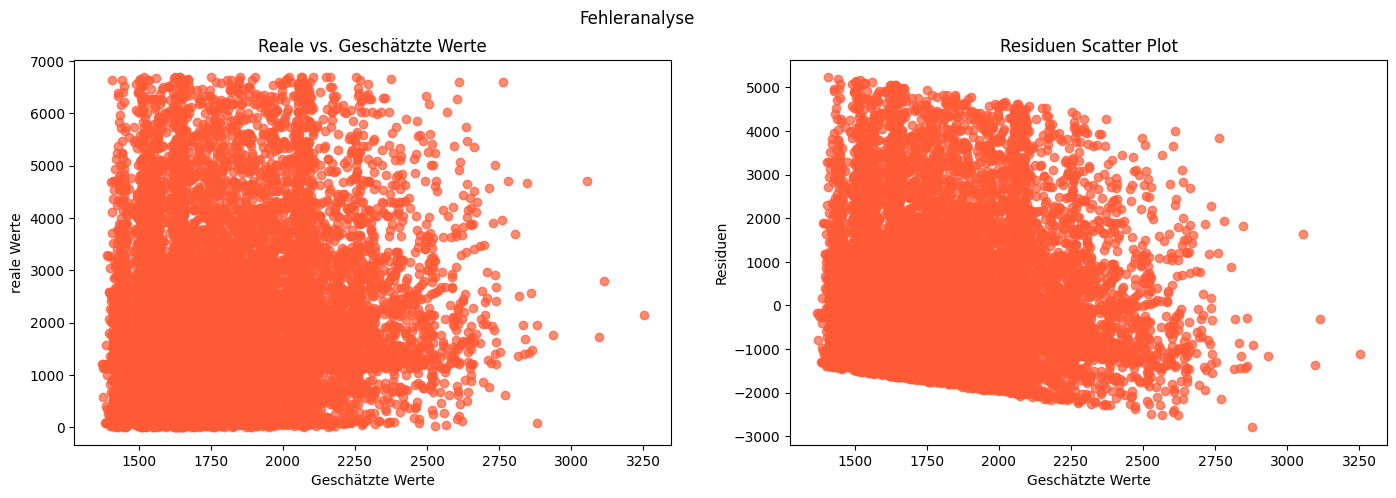

In [113]:
error_analysis(y_train, y_pred_train_m2)

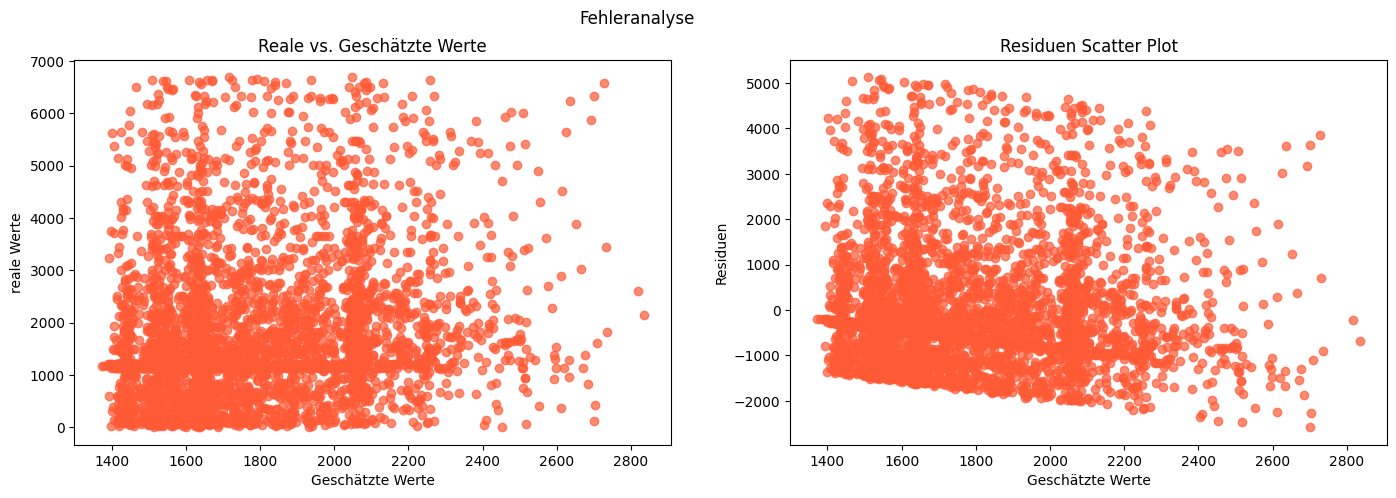

In [114]:
error_analysis(y_test, y_pred_test_m2)

In der Fehleranalyse fällt folgendes auf:
- unsere Schätzungen bewegen sich ausschließlich zwischen ca. 1400 und ca. 3000, wohingegen die tatsächlichen Werte zwischen ca. 1 und 7000 liegen, d.h. unser Modell eignet sich aktuell nicht zur Schätzung von Schäden < 1400 und > 3000;
- die Residuen sollten eigentlich gleichverteilt sein und keine bestimmte Pattern aufweisen; dies ist jedoch nicht der Fall 

Nächste Schritte könnten sein: 
- mehr Feature-Engineering
- log-transformierte abhängige Variable benutzen
- Ridge, Lasso Regression ausprobieren
- separate Modelle für bestimmte Schadenbereiche bzw. Schadenhöhengruppen etablieren 
- andere Modelle ausprobieren (ein lineares Modell scheint nicht geeignet zu sein?!) 